# Modelagem Epidemiológica da COVID-19 com o Modelo SIRC  
## Ajuste direto de parâmetros via `lmfit.Model`

Este notebook apresenta uma simulação epidemiológica baseada no modelo **SIRC** (*Susceptible–Infectious–Recovered–Confirmed*), aplicada aos dados reais da primeira onda da COVID-19 no Brasil.

O foco principal é **estimar parâmetros epidemiológicos fundamentais**, como:
- taxa de transmissão (β),
- taxa de recuperação (γ),

por meio do **ajuste direto do modelo dinâmico aos dados observados** de casos acumulados.

A abordagem utilizada neste notebook é um **ajuste não linear por mínimos quadrados**, implementado com a biblioteca `lmfit`, tratando o modelo SIRC como uma função observável direta.

## 1. Objetivo

O objetivo deste estudo é **ajustar um modelo epidemiológico do tipo SIRC** aos dados observados da COVID-19, considerando os **primeiros 150 dias da pandemia** (primeira onda).

Especificamente, busca-se:
- estimar os parâmetros β (transmissão) e γ (recuperação);
- avaliar a capacidade do modelo SIRC em reproduzir a evolução dos **casos acumulados**;
- comparar visualmente o ajuste do modelo aos dados reais.

O estudo é aplicado ao estado do **Pará**, com dados agregados a partir de registros municipais.

## 2. Dados Utilizados

Os dados utilizados neste estudo foram obtidos da base pública:

- **Brasil.io — COVID-19**
  - https://brasil.io/dataset/covid19/caso_full/

A partir dessa base:
- os dados são agregados por data e estado;
- seleciona-se o estado do **Pará (PA)**;
- utiliza-se a série temporal de **novos casos confirmados**;
- os casos acumulados são obtidos via soma cumulativa.

A análise concentra-se no período inicial da pandemia, correspondente aos **primeiros 150 dias** após o início dos registros.


In [1]:
import numpy as np
import pandas as pd
from scipy.integrate import odeint
import lmfit
import matplotlib.pyplot as plt
import modelos_epidemiologicos as model
from datetime import datetime

print(datetime.now().isoformat(timespec='seconds'))

2026-01-07T15:07:44


## 3. Leitura e Pré-processamento dos Dados

Nesta etapa, os dados brutos são:
- carregados a partir de um arquivo no formato `parquet`;
- convertidos para o tipo `datetime`;
- agregados por data e unidade federativa;
- filtrados para o estado do Pará.

Em seguida:
- calcula-se a série de **casos acumulados**;
- define-se o vetor de tempo associado à série observada.

Esses dados servirão como referência para o ajuste do modelo epidemiológico.


In [2]:
# leitura dados
df0= pd.read_parquet("/home/akel/PycharmProjects/Endemic_model/data/caso_full.parquet")
df0['date']=pd.to_datetime(df0['date'],format='%Y-%m-%d')

dfE=df0.groupby(['date', 'state'])['new_confirmed'].sum().reset_index() #agrupar por estados
dfPA= dfE[dfE['state']=='PA' ]                                          #filtrar estado
dfbel= df0[(df0["city"] == "Belém") & (df0['state']=='PA') ]            #filtrar cidade
print('arquivos lidos')
print(datetime.now().isoformat(timespec='seconds'))


arquivos lidos
2026-01-07T15:07:46


## 4. Visualização Exploratória

Antes do ajuste do modelo, é realizada uma visualização dos **casos acumulados observados** ao longo do tempo.

Essa etapa permite:
- identificar o comportamento geral da curva epidêmica;
- verificar a presença de crescimento aproximadamente exponencial no início;
- avaliar visualmente a janela temporal escolhida para o ajuste.

A visualização inicial é fundamental para garantir coerência entre os dados e o modelo proposto.


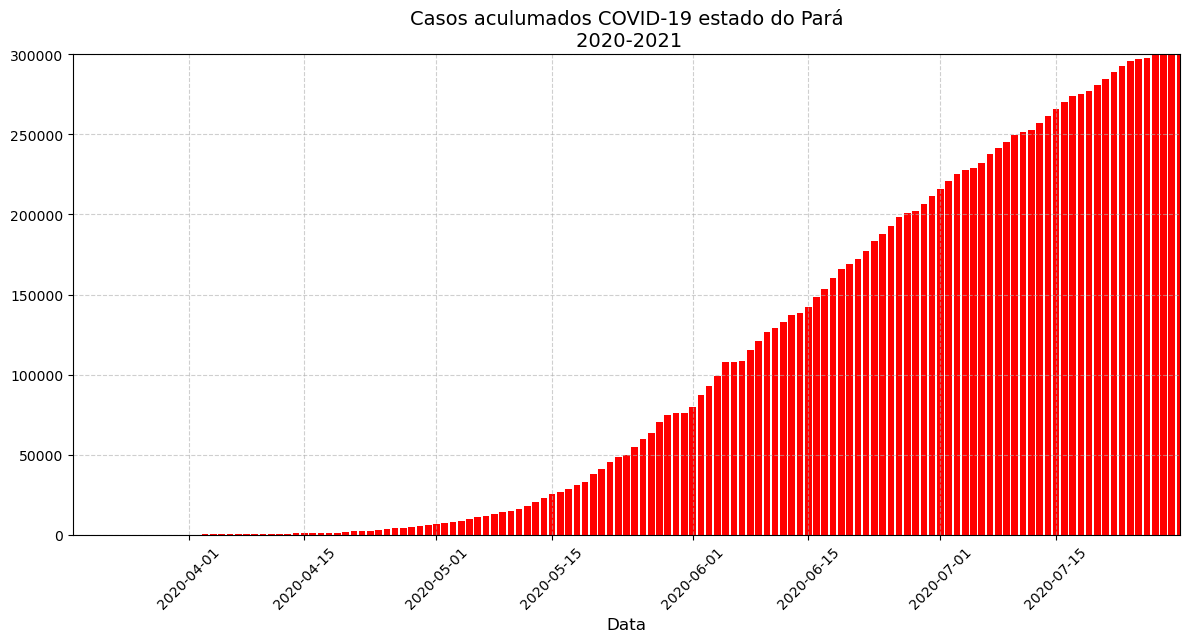

In [3]:
# Visualização
NCP=dfPA['new_confirmed'].values
NCB=dfbel['new_confirmed'].values

# casos acumulados
Cp=np.cumsum(NCP)
Cb=np.cumsum(NCB)

t_date=dfPA['date'].values

# periodo -01/02/2020 - 12/07/2020 (318)
yc=NCP[0:150]
y=Cp[0:150]
x=t_date[0:150] 

plt.figure(figsize=(12, 6))
plt.bar(x, y, color='red', label='Dados originais')
plt.title('Casos aculumados COVID-19 estado do Pará\n 2020-2021', fontsize=14)
plt.xlabel('Data', fontsize=12)
plt.tight_layout()
plt.ylim([0,300000])
plt.xlim(pd.to_datetime(['2020-03-18', '2020-07-30'])) 
plt.grid(True, linestyle='--', alpha=0.6)
plt.xticks(rotation=45);  # Rotaciona as datas para melhor legibilidade

## 5. Modelo Epidemiológico SIRC

O modelo SIRC é uma extensão do modelo SIR clássico, incorporando explicitamente a variável de **casos confirmados acumulados**.

As variáveis do modelo são:
- **S(t)**: população suscetível,
- **I(t)**: população infectada,
- **R(t)**: população recuperada,
- **C(t)**: casos acumulados confirmados.

O sistema é descrito por um conjunto de equações diferenciais ordinárias (EDOs), que governam a dinâmica de transmissão e recuperação da doença ao longo do tempo.

## 6. Solução Numérica do Modelo

O sistema de equações diferenciais do modelo SIRC não possui solução analítica fechada.

Portanto, sua solução é obtida por **integração numérica**, utilizando métodos clássicos de resolução de EDOs disponíveis na biblioteca `SciPy`.

A saída da integração fornece a evolução temporal de todas as variáveis do modelo, em particular dos **casos acumulados simulados**, que serão comparados aos dados observados.

## 7. Formulação do Problema de Ajuste

O ajuste do modelo consiste em encontrar os valores dos parâmetros β e γ que minimizam a diferença entre:
- os **casos acumulados simulados pelo modelo**, e
- os **casos acumulados observados nos dados reais**.

Matematicamente, o problema é formulado como um ajuste não linear por mínimos quadrados:

$\min_{\beta, \gamma} \sum_t \left( C_{\text{modelo}}(t) - C_{\text{dados}}(t) \right)^2$

Neste notebook, essa formulação é tratada de forma **direta**, encapsulando o modelo completo em uma função ajustável.




In [4]:
#funcoes
def solve_sirc(t,N,beta,gamma,I0):
    """Resolve o modelo SIRC e retorna casos acumulados."""
    R0 = 0
    C0 = I0
    S0 = N - I0 - R0
    y0 = [S0, I0, R0, C0]
    sol = odeint(model.SIRC, y0, t, args=(N, beta, gamma))
    return sol[:, 3]

print(datetime.now().isoformat(timespec='seconds'))

2026-01-07T15:07:46


## 8. Estimativa de Parâmetros Iniciais

Para melhorar a estabilidade e a convergência do processo de ajuste, são estimados valores iniciais aproximados para:
- população efetiva N,
- número inicial de infectados I₀,
- taxas iniciais de transmissão (β) e recuperação (γ).

Essas estimativas são obtidas a partir de um ajuste preliminar baseado em uma **função logística**, aplicada aos dados de casos acumulados.

Embora aproximadas, essas estimativas fornecem um ponto de partida fisicamente plausível para o processo de otimização.


In [5]:
c = y                  
t = np.arange(len(c))
#I0=1.728745
#N=700000
# gamma_i=0.291505
# beta_i=0.437257

R0 = 0
#C0 = I0             # Casos acumulados iniciais = infectados iniciais
#S0 = N  - I0 - R0
#y0 = [S0, I0, R0, C0]


# Estimar chutes inicias e N
K,r,A = model.initial_SIRC(c)

I0 = K / (A + 1)         #infectados inicias
N = 2 * K                #populacao
gamma_i = 2 * r          #taxa de recuperacao
beta_i = 1.5 * gamma_i   #taxa de contagio

# ---------------------------
# PARÂMETROS INICIAIS
# ---------------------------
print('\n' + '='*40)
print('PARÂMETROS INICIAIS'.center(40))
print('='*40)
print(f'{"I0:":<10}{I0:>30.6f}')
print(f'{"N:":<10}{N:>30.6f}')
print(f'{"gamma_i:":<10}{gamma_i:>30.6f}')
print(f'{"beta_i:":<10}{beta_i:>30.6f}')
print(datetime.now().isoformat(timespec='seconds'))


          PARÂMETROS INICIAIS           
I0:                             1.728745
N:                         708093.675215
gamma_i:                        0.291505
beta_i:                         0.437257
2026-01-07T15:07:46


## 9. Ajuste Direto do Modelo com `lmfit`

O ajuste dos parâmetros é realizado utilizando a classe `Model` da biblioteca `lmfit`.

Nesta abordagem:
- o modelo SIRC completo é tratado como uma função observável;
- o processo de integração numérica é executado internamente a cada iteração;
- os parâmetros β e γ são ajustados automaticamente para minimizar o erro quadrático.

Essa estratégia permite uma implementação compacta e declarativa do problema de ajuste.


In [8]:
# Configurar modelo
SIRC_model= lmfit.Model(solve_sirc,independent_vars=['t'])

params = SIRC_model.make_params()
params['N'].set(value=N, vary=False)
params['beta'].set(value=beta_i, min=0.001, max=3.0)
params['gamma'].set(value=gamma_i, min=0.001, max=2.0)
params['I0'].set(value=I0, vary=False)
                # min=1, max=N)
result = SIRC_model.fit(y, params, t=t)
print(result.fit_report())

[[Model]]
    Model(solve_sirc)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 52
    # data points      = 150
    # variables        = 2
    chi-square         = 7.0351e+10
    reduced chi-square = 4.7535e+08
    Akaike info crit   = 2998.91995
    Bayesian info crit = 3004.94122
    R-squared          = 0.96905196
[[Variables]]
    N:      708093.7 (fixed)
    beta:   0.51409090 +/- 0.00846905 (1.65%) (init = 0.4372568)
    gamma:  0.39552586 +/- 0.00806913 (2.04%) (init = 0.2915045)
    I0:     1.728745 (fixed)
[[Correlations]] (unreported correlations are < 0.100)
    C(beta, gamma) = +0.9973


## 10. Avaliação dos Resultados

Após o ajuste, os parâmetros estimados são analisados com base em:
- valores ótimos de β e γ;
- incertezas associadas aos parâmetros;
- métricas estatísticas como χ², AIC e BIC.

Além disso, é realizada uma comparação visual entre:
- os dados observados, e
- a curva de casos acumulados simulada pelo modelo ajustado.

Essa análise permite avaliar a qualidade do ajuste e a consistência epidemiológica dos parâmetros obtidos.


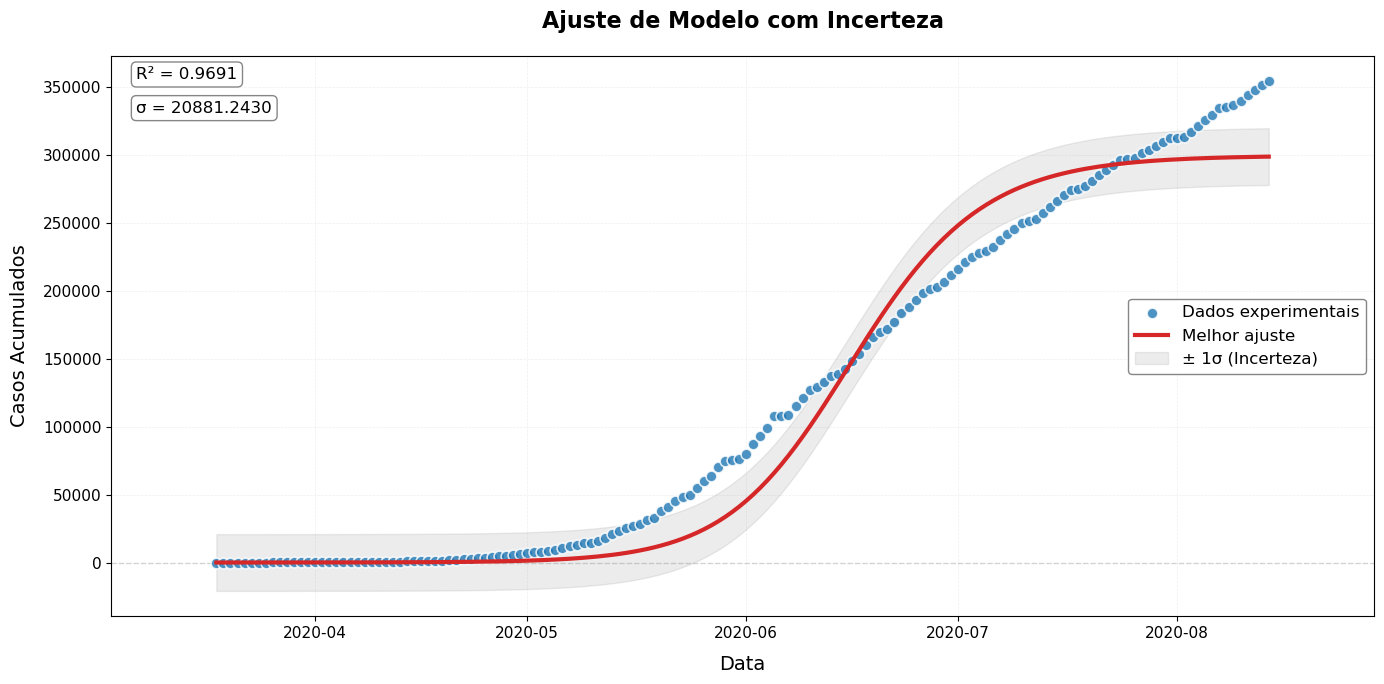

In [22]:
plt.style.use('default')  # Usar estilo padrão (branco)
plt.rcParams['font.family'] = 'DejaVu Sans'
plt.rcParams['font.size'] = 12
plt.rcParams['axes.facecolor'] = 'white'
plt.rcParams['figure.facecolor'] = 'white'

# Criar figura com eixo
fig, ax = plt.subplots(figsize=(14, 7))
fig.patch.set_facecolor('white')

# Plotar dados originais
ax.scatter(x, y, s=60, alpha=0.8, color='#1f77b4', 
           edgecolor='white', linewidth=1.2, 
           label='Dados experimentais', zorder=3)

# Plotar curva de ajuste
ax.plot(x, result.best_fit, color='#d62728', 
        linewidth=3, label='Melhor ajuste', zorder=4)

# Adicionar banda de incerteza
ax.fill_between(x, 
                 result.best_fit - result.residual.std(), 
                 result.best_fit + result.residual.std(), 
                 color='gray', alpha=0.15, 
                 label='± 1σ (Incerteza)', zorder=2)

# Linha zero para referência (opcional)
ax.axhline(y=0, color='gray', linestyle='--', alpha=0.3, linewidth=1)

# Configurar títulos e rótulos
ax.set_title('Ajuste de Modelo com Incerteza', 
             fontsize=16, fontweight='bold', pad=20)
ax.set_xlabel('Data', fontsize=14, labelpad=10)
ax.set_ylabel('Casos Acumulados', fontsize=14, labelpad=10)

# Adicionar grid sutil
ax.grid(True, alpha=0.2, linestyle='--', linewidth=0.5)

# Adicionar legenda
ax.legend(loc='best', frameon=True, framealpha=0.95, 
          edgecolor='gray', fontsize=12, shadow=False,
          facecolor='white')

# Ajustar limites e ticks
ax.set_xlim(left=min(x)-0.1*(max(x)-min(x)), 
            right=max(x)+0.1*(max(x)-min(x)))
ax.tick_params(axis='both', which='major', labelsize=11)

# Adicionar anotação com qualidade do ajuste (se disponível)
if hasattr(result, 'rsquared'):
    rsq_text = f'R² = {result.rsquared:.4f}'
    ax.text(0.02, 0.98, rsq_text, 
            transform=ax.transAxes, fontsize=12,
            verticalalignment='top',
            bbox=dict(boxstyle='round', facecolor='white', 
                     alpha=0.95, edgecolor='gray', linewidth=1))

# Adicionar anotação para desvio padrão
std_text = f'σ = {result.residual.std():.4f}'
ax.text(0.02, 0.92, std_text, 
        transform=ax.transAxes, fontsize=12,
        verticalalignment='top',
        bbox=dict(boxstyle='round', facecolor='white', 
                 alpha=0.95, edgecolor='gray', linewidth=1))

# Ajustar layout
plt.tight_layout()

# Mostrar gráfico
plt.show()


## 11- Análise dos Resultados do Ajuste do Modelo SIRC

Os resultados apresentados correspondem ao ajuste do modelo SIRC aos **casos acumulados de COVID-19 no estado do Pará**, considerando um período inicial de 150 dias da pandemia. A seguir, discute-se a qualidade do ajuste, a interpretação dos parâmetros estimados e suas implicações epidemiológicas.

---

### 🔍 Qualidade do Ajuste

O coeficiente de determinação obtido foi:


$R^2 = 0.969$

Esse valor indica que o modelo é capaz de explicar aproximadamente **97% da variabilidade observada** nos dados de casos acumulados, evidenciando uma **excelente aderência global** do modelo SIRC aos dados nesse intervalo temporal. Esse resultado sugere que a estrutura mecanística do modelo é adequada para capturar a dinâmica média de crescimento da pandemia no período analisado.

Por outro lado, o **qui-quadrado reduzido elevado** (( $\chi^2_{\text{red}}$ $\sim$ 4.8 $\times$ 10^8 )) está associado à escala absoluta dos dados (casos acumulados), que envolve números elevados. Como não foi considerada uma modelagem explícita das incertezas observacionais, esse valor não deve ser interpretado isoladamente como indicação de mau ajuste, mas sim como consequência da magnitude da variável-alvo.

Os critérios de informação:


$\text{AIC} = 2998.9, \quad \text{BIC} = 3004.9$


refletem um bom compromisso entre **qualidade do ajuste e complexidade do modelo**, especialmente considerando que apenas **dois parâmetros livres** foram estimados (( \beta ) e ( \gamma )).

---

### 🧮 Interpretação dos Parâmetros Estimados

Os valores ajustados para os parâmetros epidemiológicos foram:

$
\beta = 0.514 \pm 0.008 \quad (1.65%)
$
$
\gamma = 0.396 \pm 0.008 \quad (2.04%)
$

As **incertezas relativas baixas** indicam que os parâmetros foram bem identificados pelos dados no período analisado.

Do ponto de vista epidemiológico:

* **β (taxa de contágio)** representa a intensidade das interações efetivas capazes de gerar novas infecções;
* **γ (taxa de recuperação)** está associada ao inverso do tempo médio de infecção.

A partir desses valores, pode-se estimar o **número básico de reprodução**:

$
R_0 = \frac{\beta}{\gamma} \approx \frac{0.514}{0.396} \approx 1.30
$

Esse valor é compatível com um cenário de **crescimento epidêmico sustentado**, porém moderado, coerente com a fase inicial da pandemia e com a adoção parcial de medidas de mitigação ao longo do período.

---

### 🔗 Correlação entre Parâmetros

O ajuste revelou uma **correlação extremamente alta** entre os parâmetros ( $\beta$ ) e ( $\gamma$ ):

$
\text{Corr}(\beta, \gamma) = 0.997
$

Essa correlação quase perfeita indica que os parâmetros **não são completamente independentes**, o que é típico em modelos compartimentais ajustados a **casos acumulados**. Em termos práticos, diferentes combinações de ( $\beta$ ) e ( $\gamma$ ) podem produzir trajetórias muito semelhantes para ( C(t) ), dificultando a identificação individual de cada parâmetro.

Esse resultado sugere que:

* o ajuste é fortemente sensível à **razão ( $\beta$ / $\gamma$ )** (isto é, ao ( $R_0$ ));
* a inclusão de dados adicionais, como casos ativos ou recuperados, poderia reduzir essa degenerescência;
* modelos com parâmetros variando no tempo poderiam capturar melhor mudanças estruturais na dinâmica da epidemia.

---

### 📌 Considerações Finais

Em síntese:

* o modelo SIRC apresentou **excelente desempenho descritivo** para os dados analisados;
* os parâmetros estimados são **estatisticamente bem definidos**, porém altamente correlacionados;
* o valor estimado de ( $R_0$ ) é consistente com a dinâmica observada no período inicial da pandemia;
* os resultados reforçam tanto a **utilidade** quanto as **limitações** de modelos compartimentais simples quando aplicados a dados reais agregados.

Esses achados destacam a importância de interpretar os parâmetros epidemiológicos **em conjunto com o contexto dos dados e das hipóteses do modelo**, evitando leituras puramente numéricas dos resultados.

